# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [5]:
!pip install sweetviz

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns

#import sweetviz as sv # Библиотека для анализа датафрейма. Если не инсталлировать в jupyterhub не работает

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler # Масштабирование

from sklearn.linear_model import LinearRegression # Линейная регрессия
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from math import sqrt # Корень квадратный
from sklearn.metrics import mean_squared_error # Вычисление RMSE

import time # подсчет времени

import matplotlib.pyplot as plt

## Подготовка данных

### Загрузка файла

In [48]:
# Загружаем файлы 
df = pd.read_csv('/datasets/autos.csv')

# Смотрим общую информацию о таблице
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Анализ датафрейма

                                             |          | [  0%]   00:00 -> (? left)


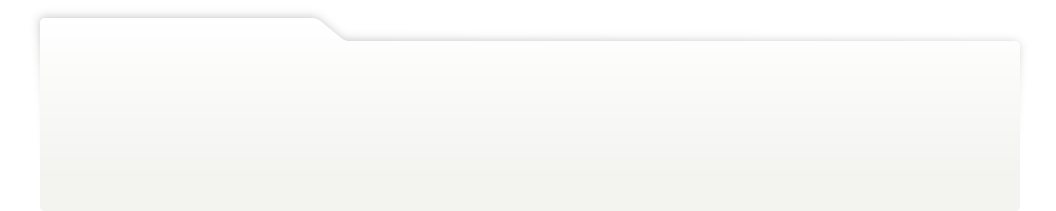
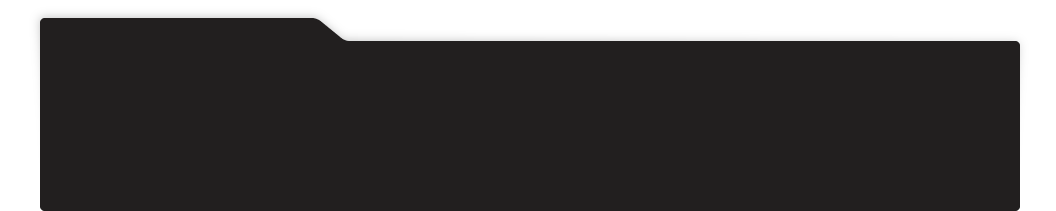
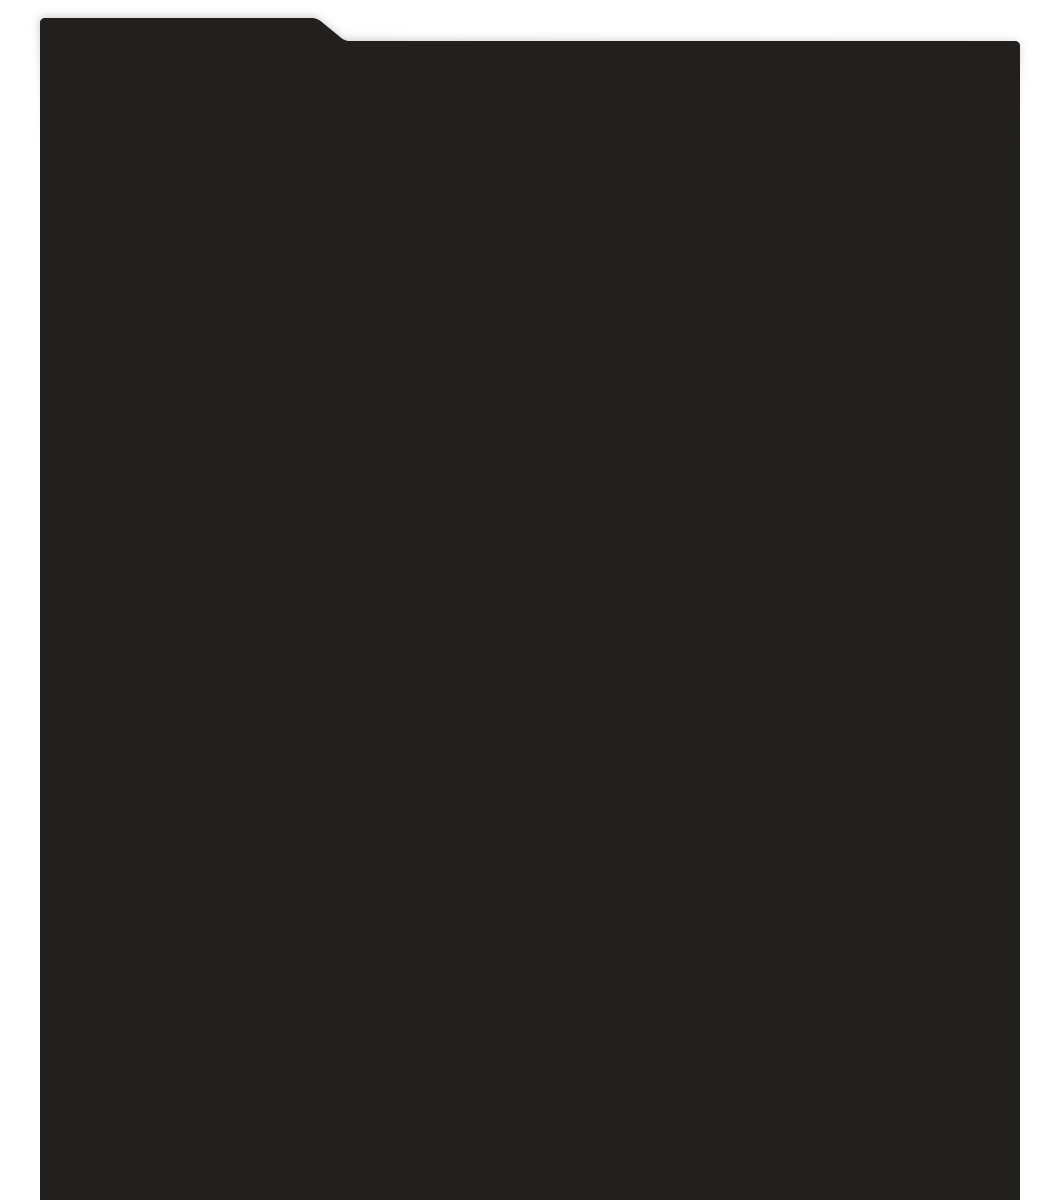
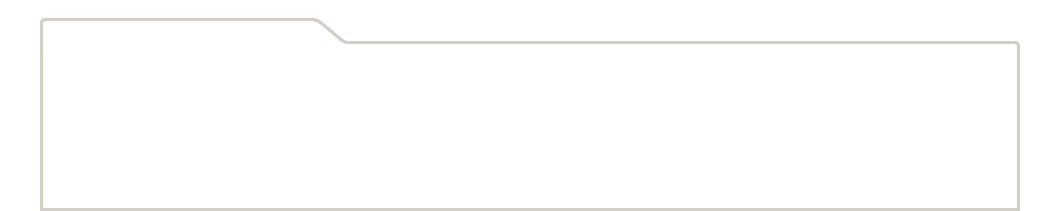
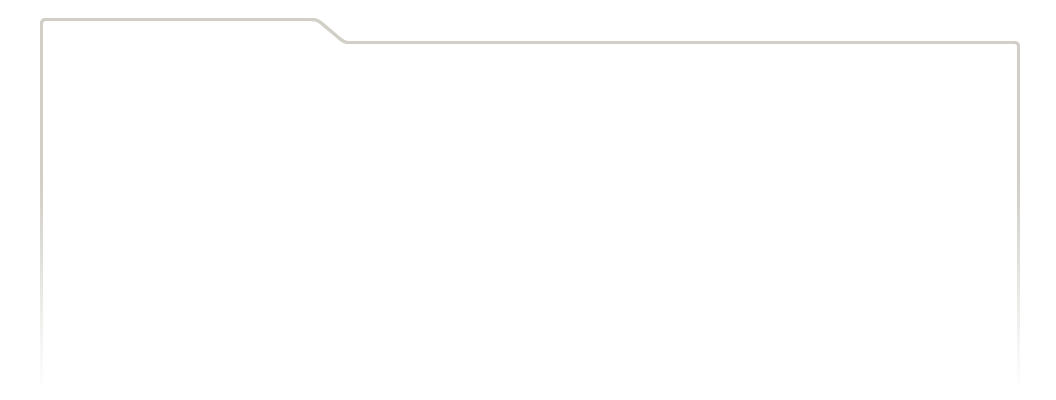
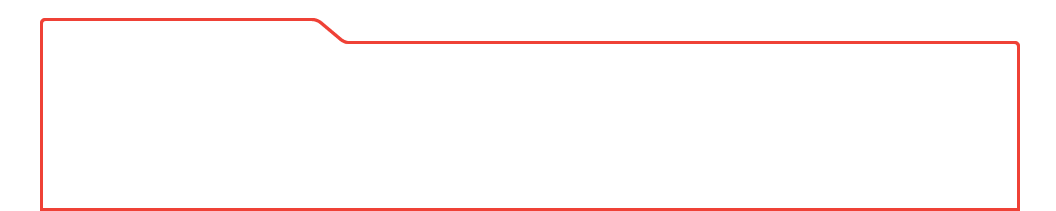
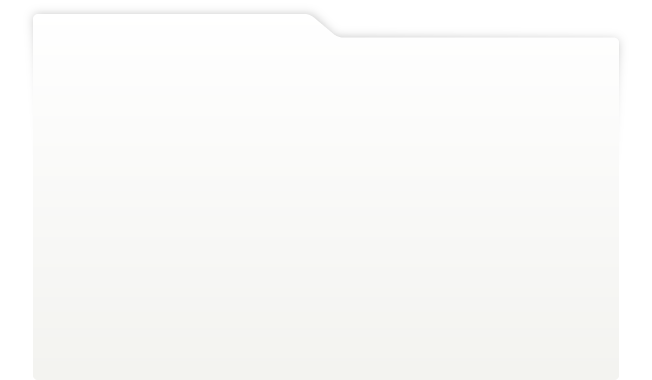
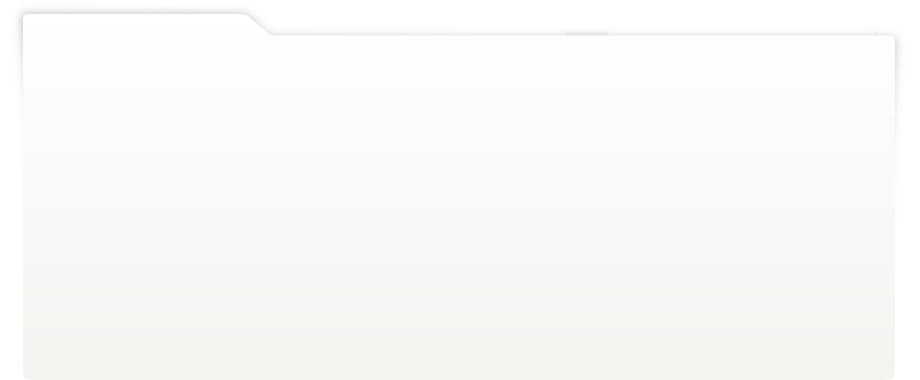
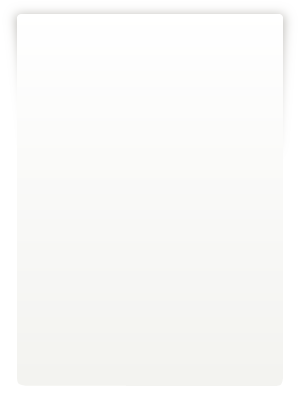
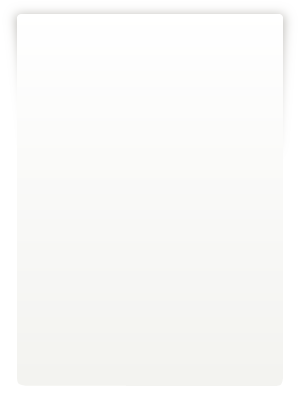
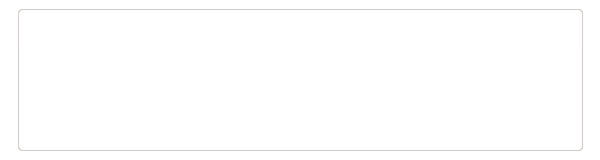
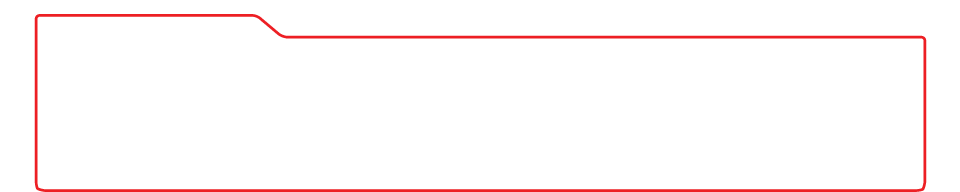
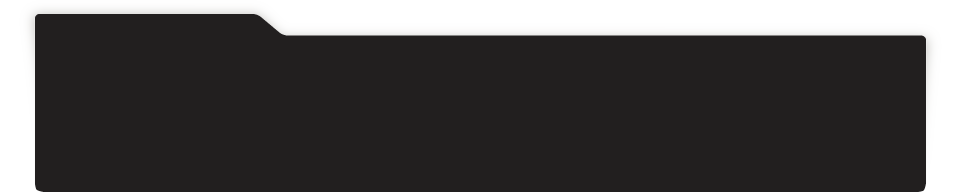
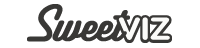
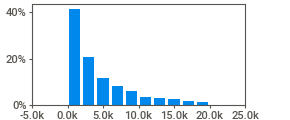
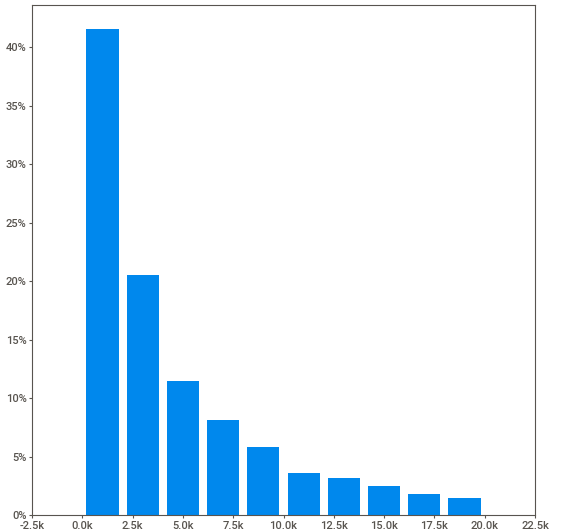
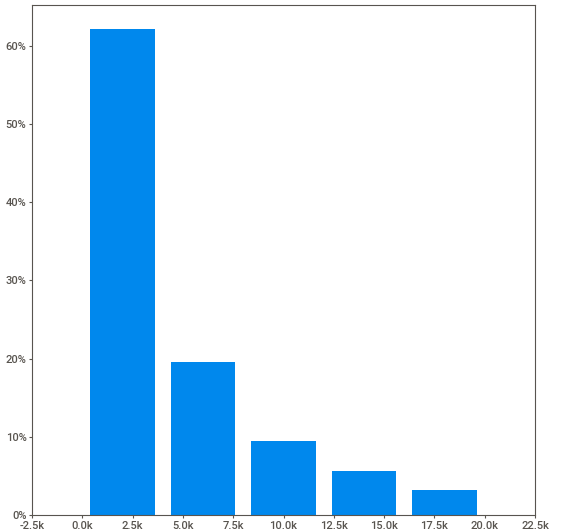
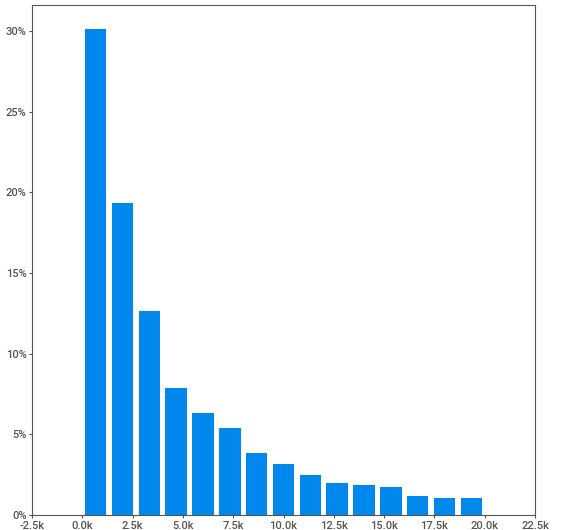
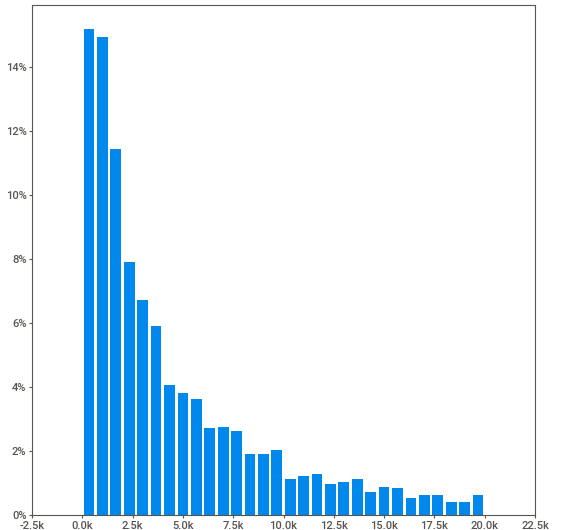
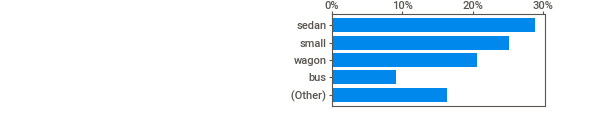
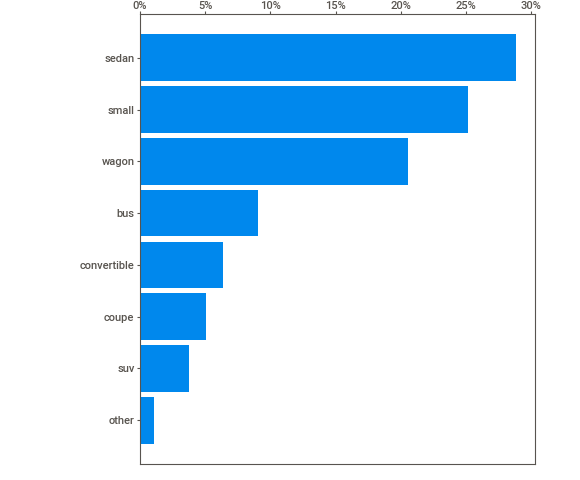
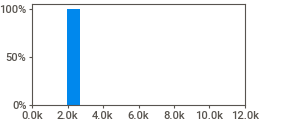
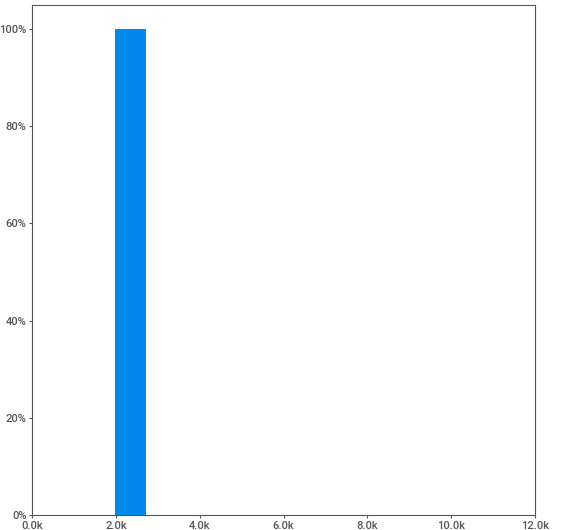
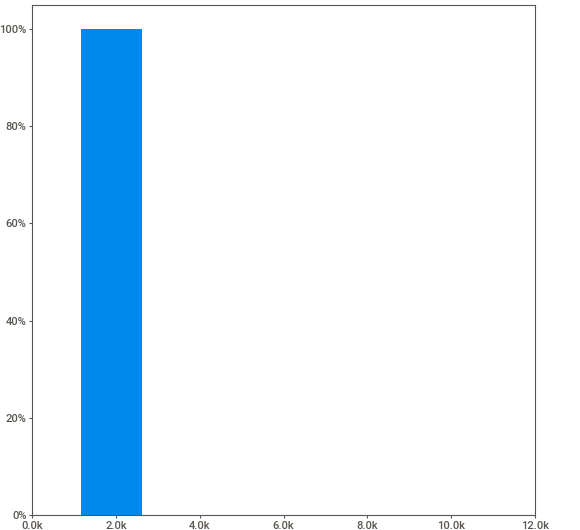
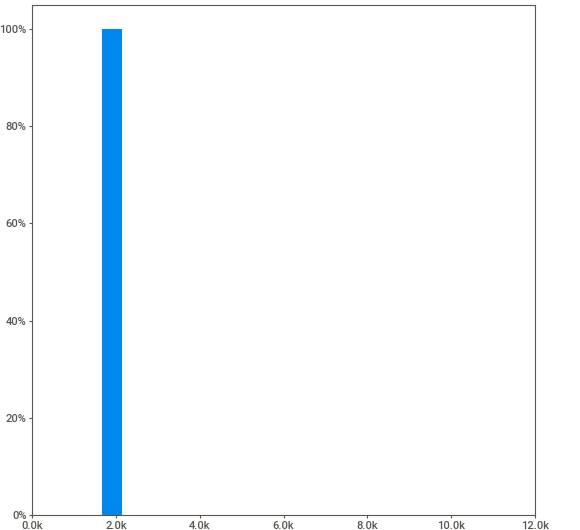
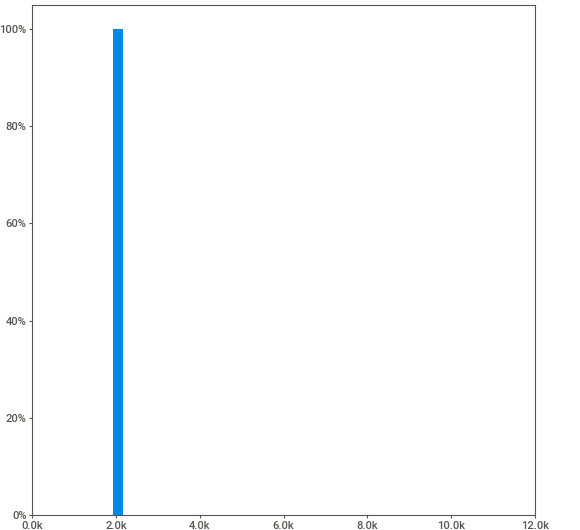
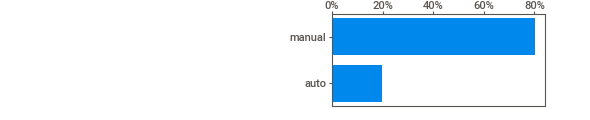
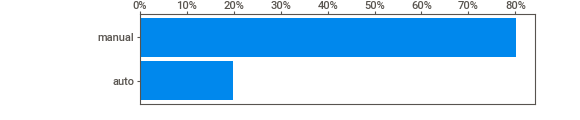
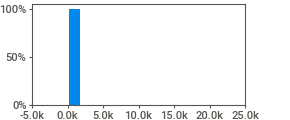
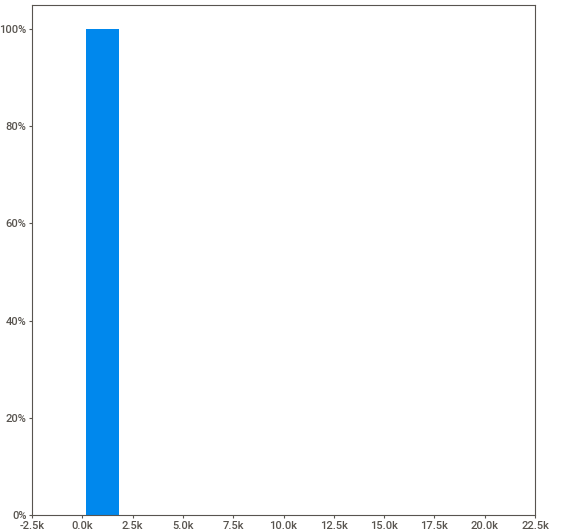
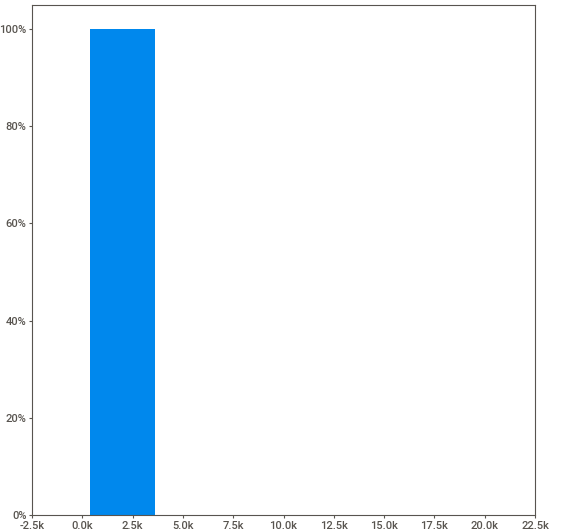
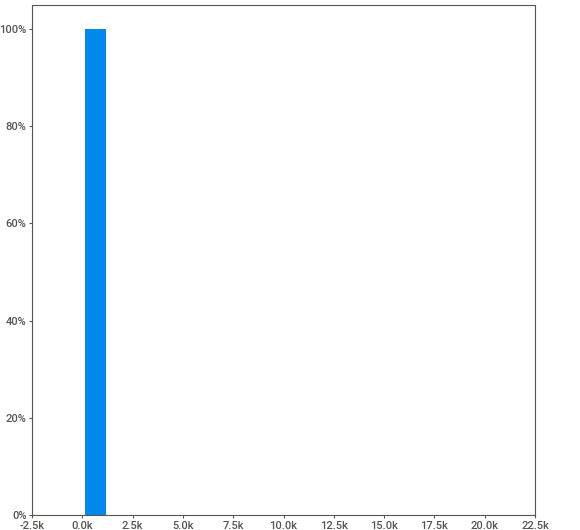
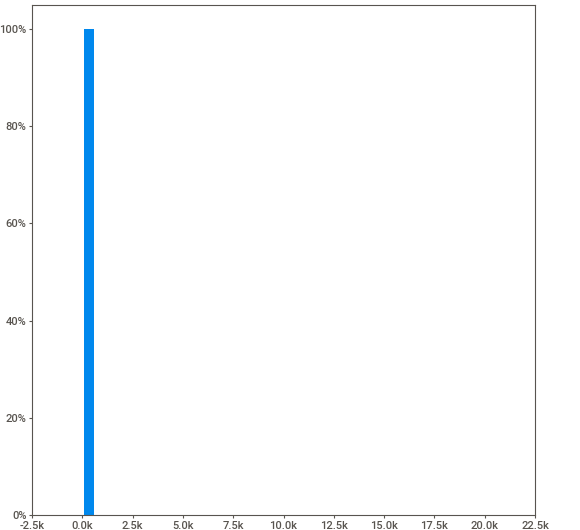
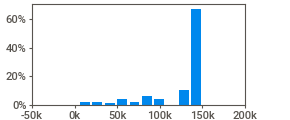
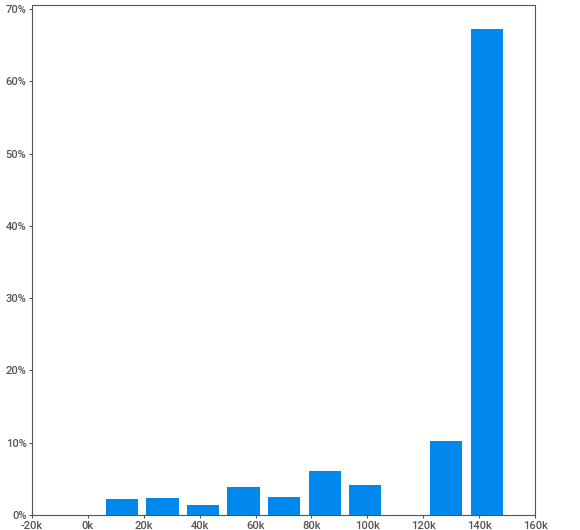
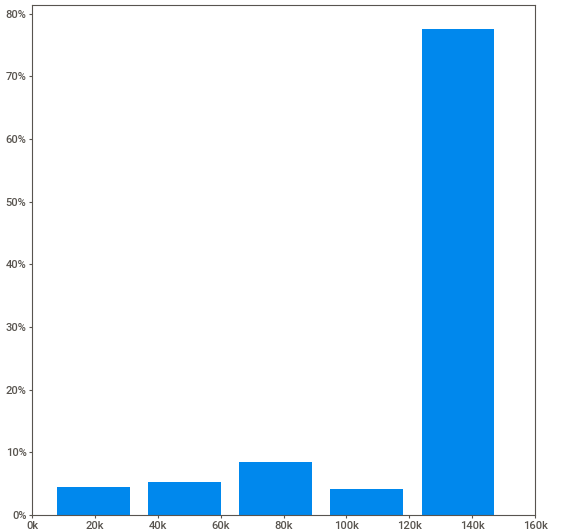
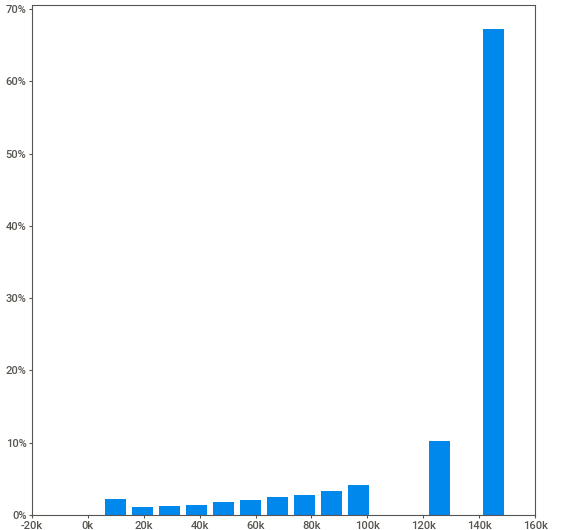
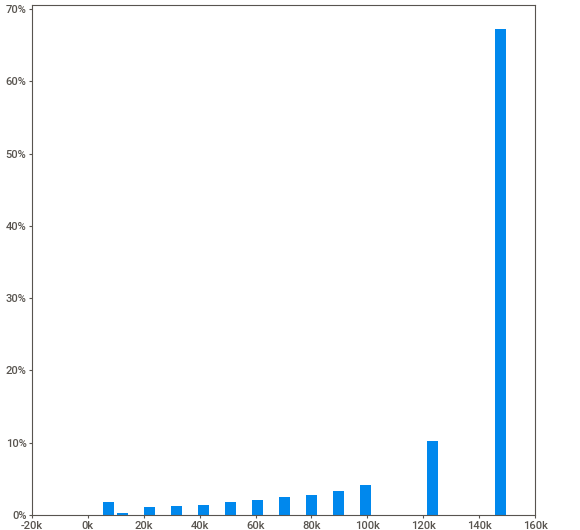
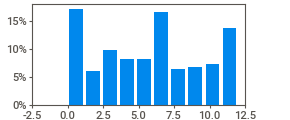
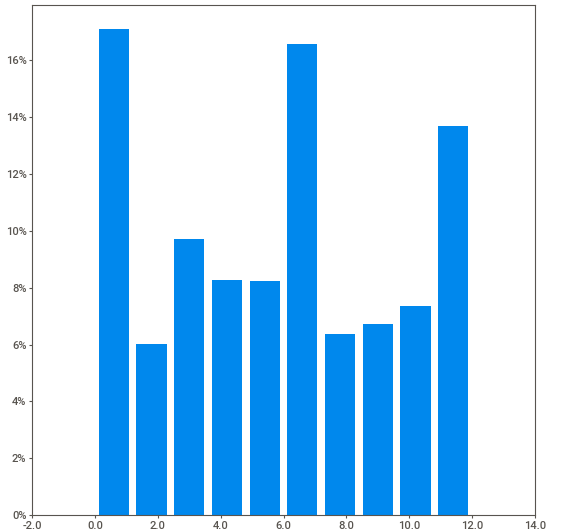
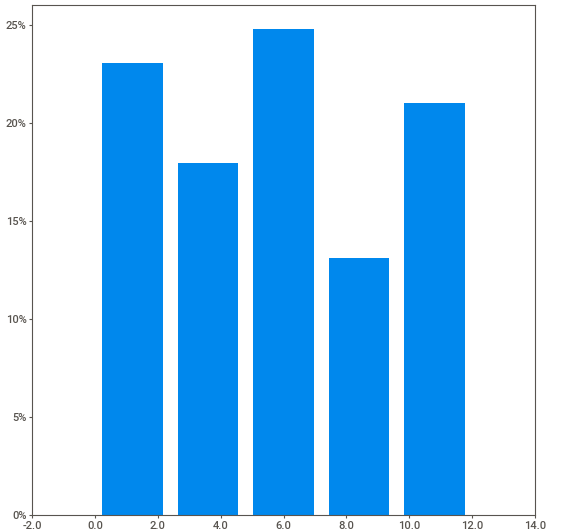
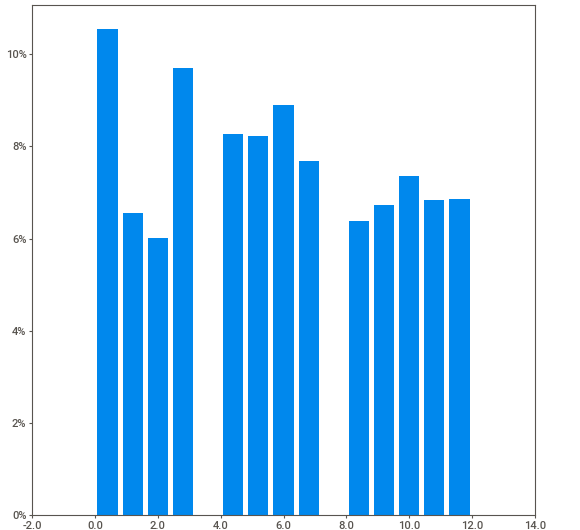
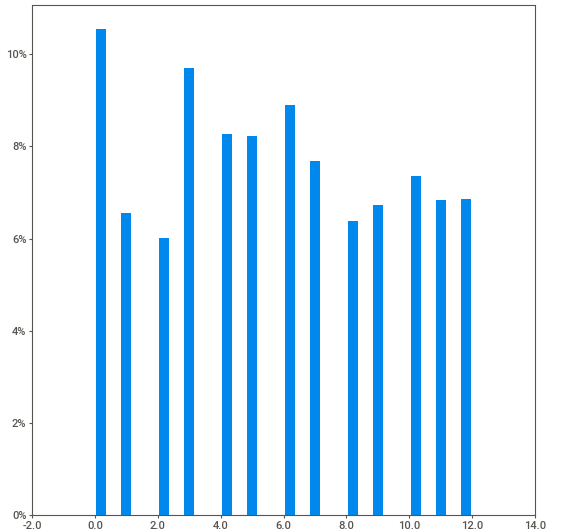
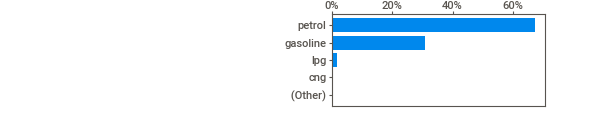
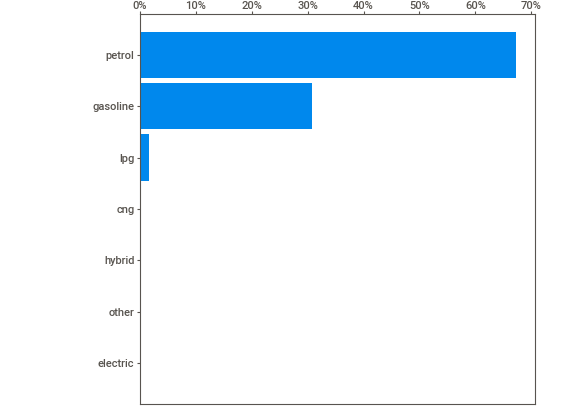
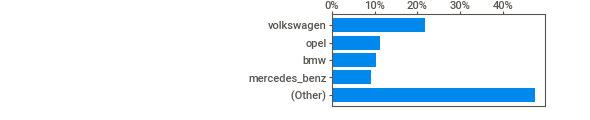
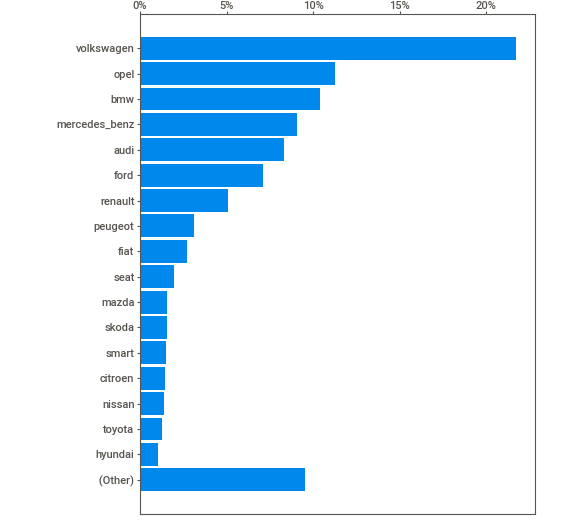
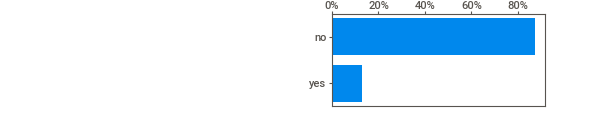
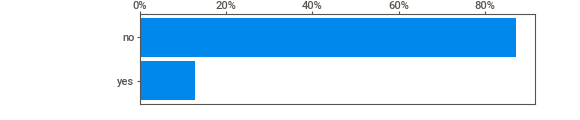
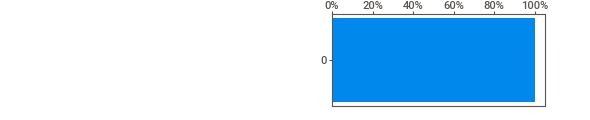
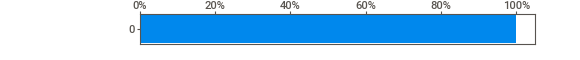
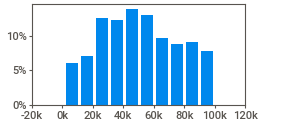
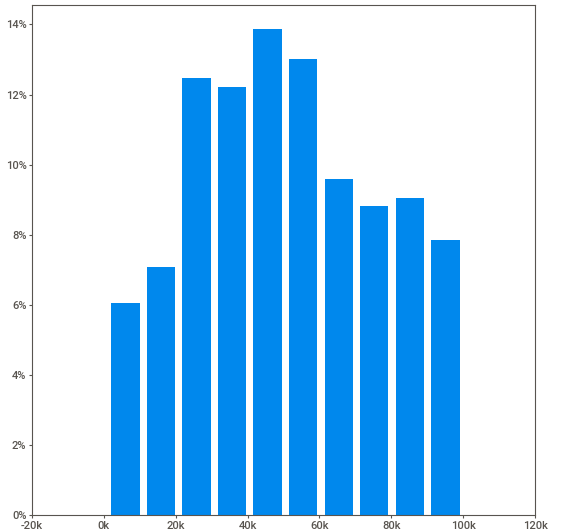
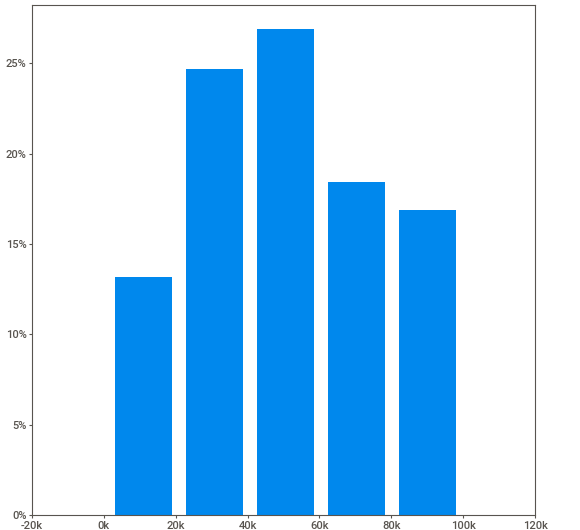
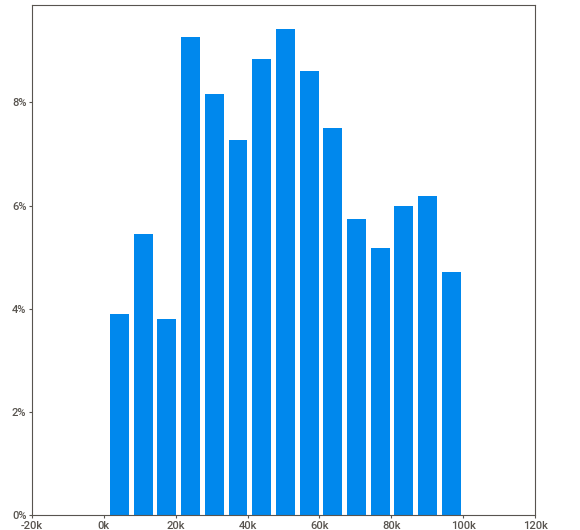
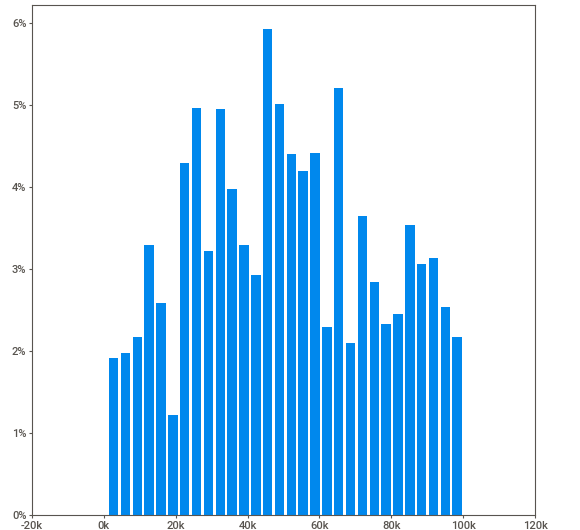
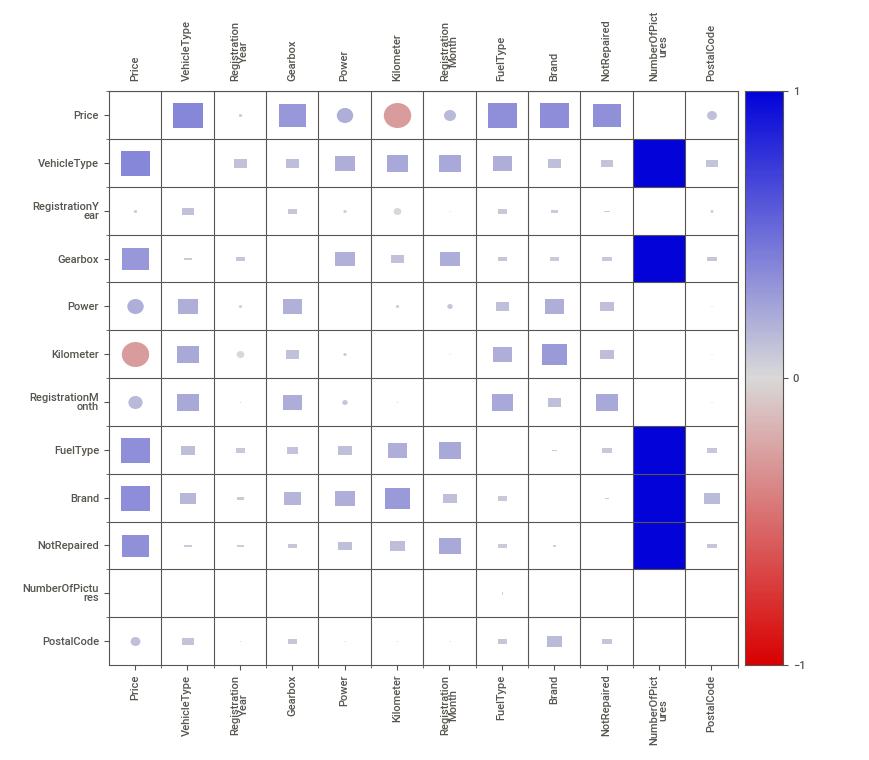
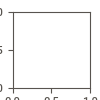

In [9]:
sweet_report = sv.analyze(df)
sweet_report.show_notebook('sweetviz_report.html')

### Удаление дубликатов

In [49]:
# Удалим дубликаты
df = df.drop_duplicates()

### Подбор необходимых признаков

Приведем расшифровку признаков

DateCrawled — дата скачивания анкеты из базы
VehicleType — тип автомобильного кузова
RegistrationYear — год регистрации автомобиля
Gearbox — тип коробки передач
Power — мощность (л. с.)
Model — модель автомобиля
Kilometer — пробег (км)
RegistrationMonth — месяц регистрации автомобиля
FuelType — тип топлива
Brand — марка автомобиля
NotRepaired — была машина в ремонте или нет
DateCreated — дата создания анкеты
NumberOfPictures — количество фотографий автомобиля
PostalCode — почтовый индекс владельца анкеты (пользователя)
LastSeen — дата последней активности пользователя
Price — цена (евро)

Исходя из расшифровки можно сделать вывод, что можно удалить следующие признаки, не влияющих на определение стоимости автомобиля - DateCrawled — дата скачивания анкеты из базы, RegistrationMonth — месяц регистрации автомобиля, DateCreated — дата создания анкеты, NumberOfPictures — количество фотографий автомобиля, PostalCode — почтовый индекс владельца анкеты (пользователя), LastSeen — дата последней активности пользователя

In [50]:
# Удалим ненужные признаки
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

### Приведение названий столбцов к змеиному виду

In [51]:
# Заменим названия столбцов на приведенные к "змеиному" виду
df = df.rename(columns={'Price':'price', 'VehicleType':'vehicle_type', 'RegistrationYear':'registration_year',
                        'Gearbox':'gearbox', 'Power':'power','Model':'model', 'Kilometer':'kilometer',
                        'FuelType':'fuel_type', 'Brand':'brand', 'NotRepaired':'not_repaired'
                         })
# Посмотрим на результат и общий вид таблицы
print(df.head())

   price vehicle_type  registration_year gearbox  power  model  kilometer  \
0    480          NaN               1993  manual      0   golf     150000   
1  18300        coupe               2011  manual    190    NaN     125000   
2   9800          suv               2004    auto    163  grand     125000   
3   1500        small               2001  manual     75   golf     150000   
4   3600        small               2008  manual     69  fabia      90000   

  fuel_type       brand not_repaired  
0    petrol  volkswagen          NaN  
1  gasoline        audi          yes  
2  gasoline        jeep          NaN  
3    petrol  volkswagen           no  
4  gasoline       skoda           no  


### Подготовка признаков

#### Признак price

In [52]:
# Поскольку наличие нулевой стоимости может негативно влиять на работу модели, а с точки зрения логики 
# отсутствие стоимости говорит скорее об ошибке- удалим такие строки
df = df.loc[df['price'] > 10]

#### Признаки gearbox, model, not_repared

1. Для признака gearbox при отсутствии указания типа - укажем 'manual' (если продавец не указывает тип, то с вероятностью 99% стоит более дешевый вариант)
2. Для признака model при отсутствии укажем - 'unknowm', поскольку определить модель по другим параметрам не представляется возможным
3. Для признака not_repared при отсутствии укажем  - 'yes', поскольку те, кто не заполнял в анкете эту графу подразумевают что автомобиль не ремонтировался

In [53]:
df = df.fillna({'gearbox':'manual', 'not_repaired':'yes', 'model':'unknown'})

#### Признак power

In [55]:
# Удалим все строки с мощностью более 1600 лошадиных сил, как нереальные
# Удалим все строки с мощностью менее 5 лошадиных сил, как маловероятные
df = df.loc[(df['power'] < 1600) & (df['power'] > 5)]

#### Признак vehicle_type

In [57]:
# Заполним пропуски в типе транспортного средства относительно типа указанного для большинства машин той же модели
df['vehicle_type'] = df['vehicle_type'].fillna(df.groupby('model')['vehicle_type']
                                                 .transform(lambda x: x.value_counts().idxmax()))

#### Признак fuel_type

In [58]:
# Заполним пропуски в тип топлива относительно типа указанного для большинства машин той же модели
df['fuel_type'] = df['fuel_type'].fillna(df.groupby('model')['fuel_type']
                                             .transform(lambda x: x.value_counts().idxmax())                                          )

#### Признак registration_year

In [60]:
# Удалим нереальные года регистрации автомобилей
df = df.loc[(df['registration_year'] > 1910) & (df['registration_year'] < 2022)]

In [62]:
# Посмотрим результат
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306102 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              306102 non-null  int64 
 1   vehicle_type       306102 non-null  object
 2   registration_year  306102 non-null  int64 
 3   gearbox            306102 non-null  object
 4   power              306102 non-null  int64 
 5   model              306102 non-null  object
 6   kilometer          306102 non-null  int64 
 7   fuel_type          306102 non-null  object
 8   brand              306102 non-null  object
 9   not_repaired       306102 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.7+ MB


### Подготовка данных для моделей Ridge() и LinearRegression() 

In [63]:
# Проведем прямое кодирование переменных
df_l = pd.get_dummies(df, columns=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired'], drop_first=True)

In [64]:
# Создание признаков
features_l = df_l.drop(['price'], axis=1)

# Создание целевого признака
target_l = df_l['price']

# отделим 25% данных для валидационной выборки
features_train_l, features_test_l, target_train_l, target_test_l = train_test_split(
features_l, target_l, test_size=0.25, random_state=12345)
    
# Сформируем таблицу для проверки разделения выборки (использовал при отладке)
data = {'Размер выборки':[len(features_train_l), len(features_test_l)], 
        'В % от общего количества':[len(features_train_l)/len(features_l)*100, len(features_test_l)/len(features_l)*100] } 
selections = pd.DataFrame(data, index =['Тренировочная выборка', 'Тестовая выборка']) 
display(selections)
    


,Размер выборки,В % от общего количества
Тренировочная выборка,229576,74.999837
Тестовая выборка,76526,25.000163


### Подготовка данных для моделей CatBoostRegressor() и LightGBM

In [65]:
# Присвоим столбцам тип 'category'
df = df.astype({'vehicle_type':'category', 'gearbox':'category', 'model':'category',
                'fuel_type':'category', 'brand':'category', 'not_repaired':'category'})

# Зададим категориальный признаки
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [66]:
# Создание признаков
features = df.drop(['price'], axis=1)

# Создание целевого признака
target = df['price']

# отделим 25% данных для валидационной выборки
features_train, features_test, target_train, target_test = train_test_split(
features, target, test_size=0.25, random_state=12345)
    
# Сформируем таблицу для проверки разделения выборки (использовал при отладке)
data = {'Размер выборки':[len(features_train), len(features_test)], 
        'В % от общего количества':[len(features_train)/len(features)*100, len(features_test)/len(features)*100] } 
selections = pd.DataFrame(data, index =['Тренировочная выборка', 'Тестовая выборка']) 
display(selections)

,Размер выборки,В % от общего количества
Тренировочная выборка,229576,74.999837
Тестовая выборка,76526,25.000163


### Выводы

После проведения анализа исходных данных были реализованы следующие действия для подготовки их к работе:
- удалены дубликаты
- удалены признаки, которые не влияют на работу модели по данному заданию - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen 
- названия столбцов приведены к "змеиному" виду
- из признака price удалены все строки с нулевой стоимостью
- заменены значения nan в признаках gearbox - на 'manual', model - на 'unknow', not_repared - на 'yes'
- в признаке power удалены значения свыше 1600 л.с. как нереальные
- в признаках vehicle_type и fuel_type значения nan заменены относительно средних значений по модели
- подготовлены данные для моделей Ridge() и LinearRegression() 
- подготовлены данные для моделей CatBoostRegressor() и LightGBM

## Обучение моделей

### Создание функции для сбора данных

In [86]:
#Создадим функцию для сбора данных
model_list = []
duration_list = []
duration_pred_list = []
rmse_list = []
gread_time_list = []

def summary (model, duration, duration_pred, rmse, gread_time):
    model_list.append(model)
    duration_list.append(duration)
    duration_pred_list.append(duration_pred)
    rmse_list.append(rmse)
    gread_time_list.append(gread_time)    

### Обучение моделей Ridge() и LinearRegression()

#### Обучение модели Ridge() до масштабирования признаков

In [87]:
%%time

clf = Ridge()

# Начало отсчета времени обучения модели
start_time = time.time()

clf.fit(features_train_l, target_train_l)

#Расчет времени обучения модели
duration = time.time() - start_time

# Начало отсчета времени предсказания
start_time = time.time()

# предсказания модели на тестовой выборке
target_predict = clf.predict(features_test_l) 

#Расчет времени предсказания
duration_pred = time.time() - start_time

# Расчет RMSE
result_l = sqrt(mean_squared_error(target_test_l, target_predict))
print('RMSE модели:', result_l)

# Сбор данных
summary('Ridge', duration, duration_pred,  result_l, 0)

RMSE модели: 2759.025286623004
CPU times: user 1.92 s, sys: 1.01 s, total: 2.93 s
Wall time: 2.88 s


#### Обучение модели LinearRegression() до масштабирования признаков

In [88]:
%%time

model_lr = LinearRegression() 

# Начало отсчета времени обучения модели
start_time = time.time()

# Обучаем модель на тренировочной выборке
model_lr.fit(features_train_l, target_train_l) 

#Расчет времени обучения модели
duration = time.time() - start_time

# Начало отсчета времени предсказания
start_time = time.time()

# предсказания модели на валидационной выборке
target_predict = model_lr.predict(features_test_l) 

#Расчет времени предсказания
duration_pred = time.time() - start_time

# Расчет RMSE
result_l = sqrt(mean_squared_error(target_test_l, target_predict))
print('RMSE модели:', result_l)

# Сбор данных
summary('LinearRegression', duration, duration_pred, result_l, 0)

RMSE модели: 2759.08545884671
CPU times: user 18 s, sys: 6.15 s, total: 24.1 s
Wall time: 24.1 s


#### Масштабирование признаков

In [18]:
# Отмасштабируем данные
scaler = StandardScaler()

# Обучаем модель на тренировочной выборке
scaler.fit(features_train_l)

# Масштабируем тренировочную и валидационные выборки
features_train_l = scaler.transform(features_train_l)
features_valid_l = scaler.transform(features_test_l) 

#### Обучение модели Ridge() после масштабирования признаков

In [19]:
%%time

clf = Ridge()
clf.fit(features_train_l, target_train_l)

# предсказания модели на тестовой выборке
target_predict = clf.predict(features_test_l) 
# Расчет RMSE
result_l = sqrt(mean_squared_error(target_test_l, target_predict))
print('RMSE модели:', result_l)

RMSE модели: 222912498.7520195
CPU times: user 3.09 s, sys: 1.63 s, total: 4.72 s
Wall time: 4.73 s


#### Обучение модели LinearRegression() после масштабирования признаков

In [20]:
%%time

model_lr = LinearRegression() 

# Обучаем модель на тренировочной выборке
model_lr.fit(features_train_l, target_train_l) 

# предсказания модели на валидационной выборке
target_predict = model_lr.predict(features_test_l) 
# Расчет RMSE
result_l = sqrt(mean_squared_error(target_test_l, target_predict))
print('RMSE модели:', result_l)

RMSE модели: 21167685759094.71
CPU times: user 19.2 s, sys: 6.88 s, total: 26.1 s
Wall time: 26 s


Можно сделать вывод, что масштабирование признаков ухудшает качество модели

### Обучение модели CatBoostRegressor()

In [61]:
%%time

# Начало отсчета времени выполнения ячейки
start_time = time.time()

cat_model = CatBoostRegressor(cat_features=cat_features)

# Зададим подбираемые параметры
param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7]}

grid_search_cat = GridSearchCV(estimator = cat_model, param_grid = param_grid, verbose = 0,
                           cv = 3, n_jobs = -1)

# Подберем параметры
grid_search_cat.fit(features_train, target_train)

#Расчет времени выполнения ячейки
duration_gread = time.time() - start_time

print(grid_search_cat.best_params_)

0:	learn: 3722.2608513	total: 182ms	remaining: 3m 1s
1:	learn: 3177.3051452	total: 383ms	remaining: 3m 11s
2:	learn: 2826.5013742	total: 574ms	remaining: 3m 10s
3:	learn: 2580.6683972	total: 711ms	remaining: 2m 57s
4:	learn: 2415.4516675	total: 891ms	remaining: 2m 57s
5:	learn: 2294.7487656	total: 1.05s	remaining: 2m 54s
6:	learn: 2214.0712841	total: 1.18s	remaining: 2m 47s
7:	learn: 2156.4556900	total: 1.35s	remaining: 2m 47s
8:	learn: 2104.4857652	total: 1.46s	remaining: 2m 40s
9:	learn: 2073.9575293	total: 1.55s	remaining: 2m 33s
10:	learn: 2044.6241895	total: 1.7s	remaining: 2m 32s
11:	learn: 2028.1711872	total: 1.8s	remaining: 2m 28s
12:	learn: 2011.1502024	total: 1.93s	remaining: 2m 26s
13:	learn: 1998.5803094	total: 2.05s	remaining: 2m 24s
14:	learn: 1989.1834283	total: 2.21s	remaining: 2m 25s
15:	learn: 1976.2753662	total: 2.32s	remaining: 2m 22s
16:	learn: 1965.3841994	total: 2.4s	remaining: 2m 18s
17:	learn: 1954.8318932	total: 2.55s	remaining: 2m 19s
18:	learn: 1949.0724949	

In [78]:
# Добавил, чтобы не запускать подбор параметров
# duration_gread = 100

In [89]:
%%time

# Начало отсчета времени обучения модели
start_time = time.time()


# Обучим модель с подобранными параметрами
cat_model = CatBoostRegressor(learning_rate=0.3, cat_features=cat_features,
                          iterations=1000, 
                          verbose=100) 

cat_model.fit(features_train, target_train)

#Расчет времени обучения модели
duration = time.time() - start_time

# Начало отсчета времени предсказания
start_time = time.time()

target_predict = cat_model.predict(features_test)

#Расчет времени предсказания
duration_pred = time.time() - start_time

# Расчет RMSE
result_cat = sqrt(mean_squared_error(target_test, target_predict))

# Сбор данных
summary('CatBoostRegressor', duration, duration_pred, result_cat, duration_gread)

print(result_cat)

0:	learn: 3766.7495991	total: 244ms	remaining: 4m 3s
100:	learn: 1676.3630659	total: 16.3s	remaining: 2m 24s
200:	learn: 1609.1545825	total: 33.3s	remaining: 2m 12s
300:	learn: 1570.7434672	total: 49.9s	remaining: 1m 55s
400:	learn: 1548.5999180	total: 1m 6s	remaining: 1m 38s
500:	learn: 1527.8127516	total: 1m 22s	remaining: 1m 22s
600:	learn: 1511.0535060	total: 1m 40s	remaining: 1m 6s
700:	learn: 1497.4033346	total: 1m 56s	remaining: 49.8s
800:	learn: 1484.4560657	total: 2m 13s	remaining: 33.1s
900:	learn: 1473.9925687	total: 2m 30s	remaining: 16.5s
999:	learn: 1462.6699642	total: 2m 46s	remaining: 0us
1627.4472993879135
CPU times: user 2min 48s, sys: 493 ms, total: 2min 49s
Wall time: 2min 50s


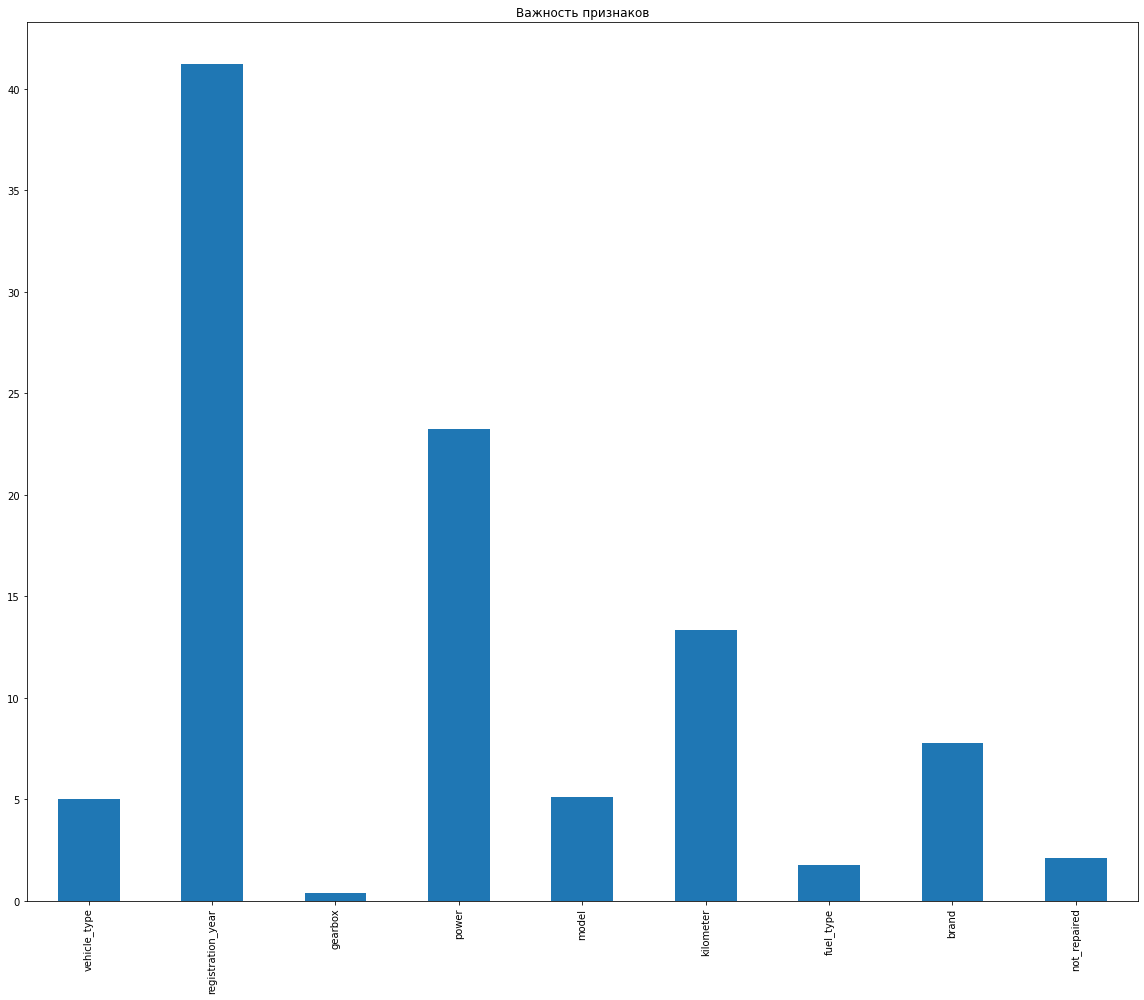

In [93]:
# Построим гистограмму для визуализации важности признаков
cat_wine_imp = pd.Series(cat_model.get_feature_importance(),
                         df.drop(['price'], axis=1).columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_wine_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

### Обучение модели LightGBM

In [65]:
lgbm = LGBMRegressor()

# Начало отсчета времени выполнения ячейки
start_time = time.time()

# Зададим подбираемые параметры
param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [15, 20, 30, 35],
             }

grid_search = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )

# Подберем параметры
grid_search.fit(features_train, target_train)

#Расчет времени выполнения ячейки
duration_gread = time.time() - start_time

print(grid_search.best_params_)

{'learning_rate': 0.3, 'max_depth': 15}


In [90]:
%%time

# Обучим модель с подобранными параметрами
lgbm = LGBMRegressor(learning_rate = 0.3, max_depth = 15)

# Начало отсчета времени обучения модели
start_time = time.time()

lgbm.fit(features_train, target_train)

#Расчет времени обучения модели
duration = time.time() - start_time

# Начало отсчета времени предсказания
start_time = time.time()

target_predict = lgbm.predict(features_test)

#Расчет времени предсказания
# duration_pred = time.time() - start_time

# Расчет RMSE
result_lgbm = sqrt(mean_squared_error(target_test, target_predict))

print(result_lgbm, duration_pred)

duration_pred = time.time() - start_time

# Сбор данных
summary('LGBMRegressor', duration, duration_pred, result_lgbm, duration_gread)

1639.7108398991747 0.701380729675293
CPU times: user 4.74 s, sys: 11.5 ms, total: 4.76 s
Wall time: 4.77 s


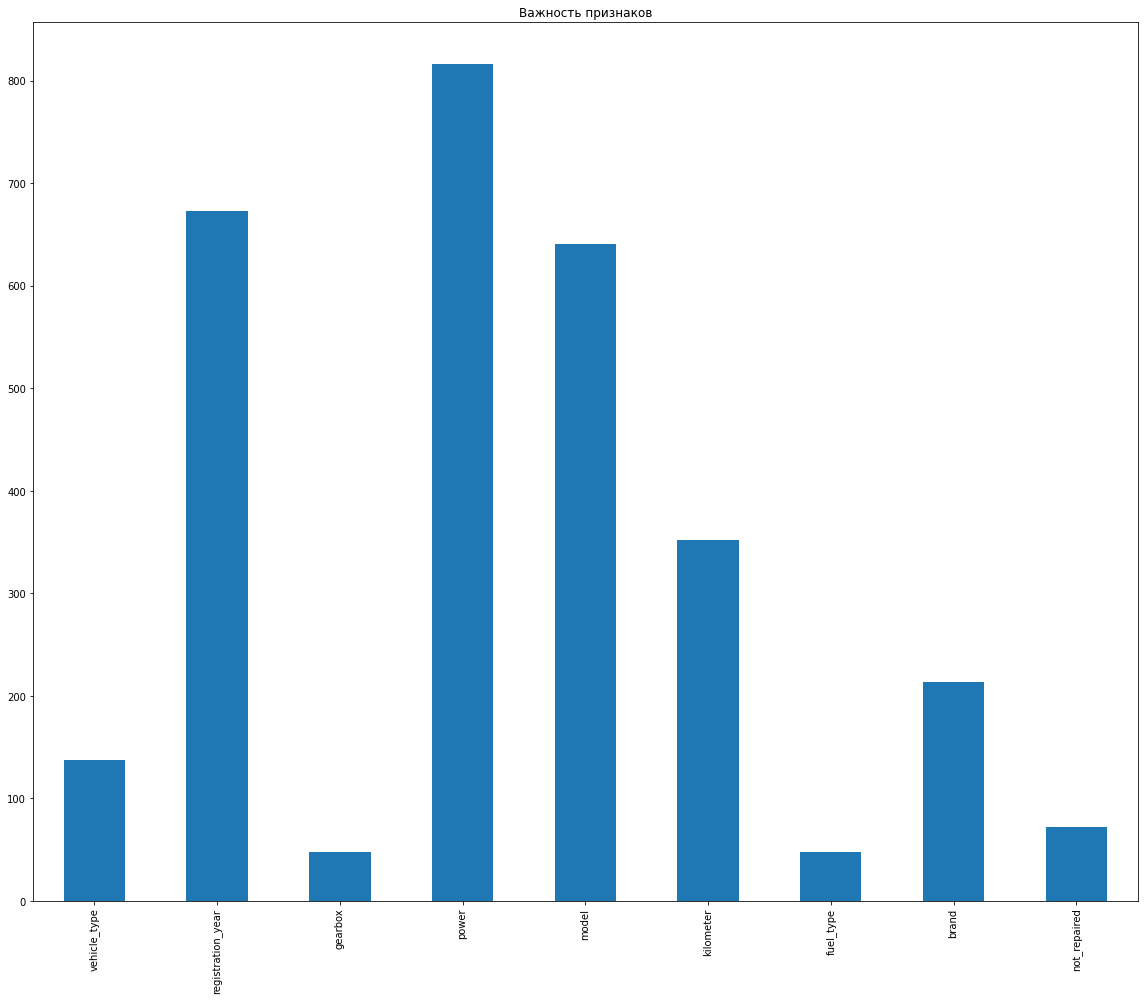

In [100]:
# Построим гистограмму для визуализации важности признаков
lgbm_wine_imp = pd.Series(lgbm.feature_importances_,
                         df.drop(['price'], axis=1).columns)
fig, ax = plt.subplots(figsize=(16,14))
lgbm_wine_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

### Выводы

Проведено обучение следующих моделей Ridge(), LinearRegression(), CatBoostRegressor() и LightGBM().
После проведения масштабирование данных для моделей Ridge() и LinearRegression() сделан вывод, что масштабирование признаков в данном случае ухудшает качество этих моделей
Для моделей  CatBoostRegressor() и LightGBM() был проведен подбор параметров

## Анализ моделей

In [91]:
# Сформируем датафрейм
results_df = pd.DataFrame(index=['Название модели', 'Продолжительность обучения модели, сек.', 'Продолжительность предсказания, сек.',  'RMSE', 'Продолжительность подбора параметров'],
                          data=[model_list, duration_list, duration_pred_list, rmse_list, gread_time_list])

results_df

,0,1,2,3
Название модели,Ridge,LinearRegression,CatBoostRegressor,LGBMRegressor
"Продолжительность обучения модели, сек.",2.478567,23.79596,169.501811,4.16624
"Продолжительность предсказания, сек.",0.39631,0.299785,0.701381,0.60611
RMSE,2759.025287,2759.085459,1627.447299,1639.71084
Продолжительность подбора параметров,0,0,100,100


### Выводы

Можно сделать следующие выводы:
- результаты работы моделей CatBoostRegressor и LGBMRegressor существенно выше результатов работы моделей Ridge и LinearRegression
- по показателю RMSE наилучшей моделью является CatBoostRegressor, но поскольку различие в RMSE с моделью LGBMRegressor незначительно, а по времени работы самой модели и подбора параметров модели LGBMRegressor существенно выигрывает, наилучшей моделью является LGBMRegressor

## Выводы

При подготовке данных
- были удалены признаки, которые не влияют на работу модели по данному заданию - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen.
- из признака price удалены все строки с нулевой стоимостью
- заменены значения nan в признаках gearbox - на 'manual', model - на 'unknow', not_repared - на 'yes'
- в признаке power удалены значения свыше 1600 л.с. как нереальные
- в признаках vehicle_type и fuel_type значения nan заменены относительно средних значений по модели

По показателю RMSE - результаты работы моделей CatBoostRegressor и LGBMRegressor существенно выше результатов работы моделей Ridge и LinearRegression, наилучший результат по этому показателю у модели CatBoostRegressor
По времени работы модели и подбора параметров модели LGBMRegressor существенно выигрывает у модели CatBoostRegressor
Учитывая незначительное различие в RMSE у LGBMRegressor и CatBoostRegressor, наилучшей моделью является -  LGBMRegressor